# Zonal statistics using polygons as zones and raster input for calculating statistics
---
Purpose: preprocess raster datasets for aggregation by SimU 

This code takes the following data inputs: 

1. national level SimUs as vector file
2. categorical* raster(s) for the years of interest

/* note: it will also accept ordinal rasters too, but you will need to then specify the stats to report

And produces a csv in the following format:

row 1: Name_1  |  FID_SimU_a  |  SimUID  |  HRU  |  Area_1000ha |  Class 1  | Class 2  |  Class n...  |  LULC_areaSum

Area of each class and area in LULC_areaSum are in units of 1000 ha

## Preamble

In [1]:
import gdal
import geopandas as gpd
import pandas as pd
import fiona as fi
import matplotlib
import matplotlib.pyplot as plt
from osgeo import ogr
import json
import geojson
import os
from rasterstats import zonal_stats
import rasterio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy as np
import time

## 1) Function to calculate zonal stats

In [2]:
def calcZS(zones, rasterPath, statsList, categorical, zones_dropCols, convUnit):
    ## rasterstats manual: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics

    ## calc zonal stats
    stats = zonal_stats(zones, rasterPath, categorical = categorical, stats=statsList, nodata = 0)

    ## convert stats output to pd df
    stats_df = pd.DataFrame(stats)
    
    ## change the index to be the same as zones to enable concatenation
    stats_df = stats_df.set_index(zones.index)
    
    ## convert pixel count to unit of interest
    stats_df = stats_df*convUnit
    ## Create new column that is the sum of all the LULC area categories
    stats_df["LULC_areaSum"] = stats_df.sum(axis = 1, skipna = True)
    
    ## concat the zones columns 
    stats_df_concat = pd.concat([pd.DataFrame(zones), stats_df], axis = 1, ignore_index = False)
    
    ## remove any excess columns from the zones df
    stats_df_concat.drop(columns = zones_dropCols, inplace = True)

    return stats_df_concat

## 2) Parameters 
set parameters, import datasets, set output file names

In [82]:
#### GENERAL PARAMETERS
dataType = "LULC_l48" ## Used to name file
year = 2016 ## used to name file
## columns in include in the final reclassified csv
columnsInFinal = ["UniqueID", "COUNTRY", "FID_cnt", "HRU", "Grd30", "State", "FID_SU_", "SimUID", "SimUIDn", "Area_km2" ,"Area_1000ha", "LULC_areaSum", \
                  "Forest" , "CrpLnd", "Grass", "OthNatLnd", "WetLnd", "NotRel", "Forest_PA" , "CrpLnd_PA", "Grass_PA", "OthNatLnd_PA", "WetLnd_PA", "NotRel_PA"]
projectVector = "yes" ## yes or not to project the zones/vector file to match the raster projection
testRun = "no" ## yes or no to run for just a state
testRun_state = "" ## if yes, this will be the state it will run
units = "1000ha" ## used to name file
viewMaxRows = 20

#### ZONAL STATS FUNCTION ARGUMENTS
## list: zones/vector column names to drop, if any
dropColsLs = [] ## ["geometry", 'oilp_yield', 'oilp_yie_1', 'oilp_yie_2']
## scalar: area of each grid cell to multiply the categorical count to get to units of 1000 ha
convUnit_a = 0.00009 
## for the above, convUnit_a = 0.00009 for landsat (30 m data) since equal to 900 m2 or 30m x 30m in units of 1000 ha (0.09 ha = 900 m2; divide by 10,000)
## boolean: whether or not the raster is categorical
categoricalRaster = True
## list: stats to calculate (none if categorical raster)
statList = []

#### INPUT FILE PATHS 
## Protected areas fgdb and feature class name
PAD_gdb_fp = r"C:\Users\Grace\Documents\FABLE\GLOBIOM\US_data\Conservation\PADUS2_0_GDB_Arc10x\PADUS2_0.gdb"
## use the feature class that has been projected to match the NLCD layer
PAD_fn = "PADUS2_0Combined_Proclamation_Marine_Fee_Designation_Easement_proj"

## Polygon (SimU) datast
SimU_fp = "C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\SimU\\gis\\SimU_all_select840_USstateSplit_proj_newSUcol.shp"

## Raster dataset
raster_fp= "C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\LULC\\NLCD\\NLCD_" + str(year) + "_Land_Cover_L48_20190424\\NLCD_" + str(year) + "_Land_Cover_L48_20190424_PAD.tif"

## legend
legend_fp = "C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\LULC\\NLCD\\legend.csv"
leg_col_1 = "Code"
leg_col_2 = "Name"

## recclassification legend
reclassLegend_fp = "C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\LULC\\NLCD\\NCLD_GLOBIOM_mapping.csv"
reclass_col_1 = "NLCD_categoryName"
reclass_col_2 = "GLOBIOM_CategoryName"

#### OUTPUT FILE PATHS
## csv filename of state land area totals (for checking later, not an output)
totalLandArea_fp = "C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\LULC\\NLCD\\processed\\" + dataType + "_totalLandArea_" + units + "_" + str(year) + testRun_state + ".csv"

## csv filename of original classes
results_fp = "C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\LULC\\NLCD\\processed\\" + dataType + "_NCLD_SimU_originalClasses_" + units + "_" + str(year) + testRun_state + ".csv"

## csv filename of reclassifed classes
results_mapped_fp = "C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\LULC\\NLCD\\processed\\" + dataType + "_NCLD_SimU_GLOBIOMclasses_" + units + "_" + str(year) + testRun_state + ".csv"

In [62]:
results_fp

'C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\LULC\\NLCD\\processed\\LULC_l48_NCLD_SimU_originalClasses_1000ha_2001.csv'

## SKIP: Remove protected areas

### Read fgdb feature class into python

In [4]:
driver = ogr.GetDriverByName("OpenFileGDB")
ds = driver.Open(PAD_gdb_fp, 0)
PAD = ds.GetLayer(PAD_fn)
print(PAD)

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x000001A310C5D600> >


In [5]:
layerDefinition = PAD.GetLayerDefn()
for i in range(layerDefinition.GetFieldCount()):
    print(layerDefinition.GetFieldDefn(i).GetName())

FeatClass
Category
Own_Type
Own_Name
Loc_Own
Mang_Type
Mang_Name
Loc_Mang
Des_Tp
Loc_Ds
Unit_Nm
Loc_Nm
State_Nm
Agg_Src
GIS_Src
Src_Date
GIS_Acres
Source_PAID
WDPA_Cd
Access
Access_Src
Access_Dt
GAP_Sts
GAPCdSrc
GAPCdDt
IUCN_Cat
IUCNCtSrc
IUCNCtDt
Date_Est
Comments
EsmtHldr
EHoldTyp
SHAPE_Length
SHAPE_Area


### Select protected polygons from PADUS feature class

In [6]:
PAD.SetAttributeFilter( "GAP_Sts = '1' or GAP_Sts = '2'" ) #("State_Nm = 'CA'")

featureCount = PAD.GetFeatureCount()
print("Number of selected features in %s: %d" % (os.path.basename(PAD_gdb_fp),featureCount))

Number of selected features in PADUS2_0.gdb: 73571


### Convert to raster, use selected areas as mask

In [ ]:
OutputImage = 'C:\\Users\\Grace\\Documents\\FABLE\\GLOBIOM\\US_data\\Conservation\\PADUS2_0_GDB_Arc10x\\processed\\PADUS_select.tif'

RefImage = raster_fp

gdalformat = 'GTiff'
datatype = gdal.GDT_Byte
burnVal = 1 #value for the output image pixels

##########################################################
# Get projection info from reference image
Image = gdal.Open(RefImage, gdal.GA_ReadOnly)

# Open Shapefile
#Shapefile = ogr.Open(InputVector)
#Shapefile_layer = Shapefile.GetLayer()
Shapefile_layer = PAD

# Rasterise
print("Rasterising shapefile...")
Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, \
                                                 Image.RasterXSize, \
                                                 Image.RasterYSize, 1, \
                                                 datatype, \
                                                 options=['COMPRESS=DEFLATE'])
Output.SetProjection(Image.GetProjectionRef())
Output.SetGeoTransform(Image.GetGeoTransform()) 

# Write data to band 1
Band = Output.GetRasterBand(1)
Band.SetNoDataValue(0)
gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

# Close datasets
Band = None
Output = None
Image = None
Shapefile = None

## SKIP: Direct way to using PADUS shapefile to clip the LULC or other input raster using earthpy functions
See tutorial here [https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/crop-raster-data-with-shapefile-in-python/]

In [40]:
## read vector object as gpd
fi.listlayers(PAD_gdb_fp)

## open the PAD feature class
PAD_gpd = gpd.read_file(PAD_gdb_fp, driver='FileGDB', layer=PAD_fn)
PAD_gpd.crs
#PAD_gpd.crs = {'init' :'epsg:4326'}

{'proj': 'aea',
 'lat_1': 29.5,
 'lat_2': 45.5,
 'lat_0': 23,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

In [41]:
## select only gap statuses 1 and 2
PAD_GAP = PAD_gpd[(PAD_gpd['GAP_Sts'] == '1') | (PAD_gpd['GAP_Sts'] =='2')]

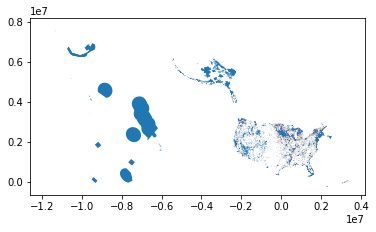

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
PAD_GAP.plot(ax=ax)

In [45]:
print('PAD rows: ', len(PAD_GAP.index))
print('PAD crs: ', PAD_gpd.crs)
print('raster crs: ', rasterio.open(raster_fp).crs)

PAD rows:  73571
PAD crs:  {'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}
raster crs:  +ellps=WGS84 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +towgs84=0,0,0,-0,-0,-0,0 +units=m +x_0=0 +y_0=0


## SKIP: Crop LULC with PAD

In [47]:
with rasterio.open(raster_fp) as LULC:
    LULC_cropped, LULC_cropped_meta = es.crop_image(LULC,PAD_GAP)

LULC_cropped_meta_affine = LULC_cropped_meta["transform"]
# Create spatial plotting extent for the cropped layer
LULC_cropped_extent = plotting_extent(LULC_cropped[0], LULC_cropped_meta_affine)

CPLE_OutOfMemoryError: memdataset.cpp, 1541: cannot allocate 1x16832104560 bytes

In [46]:
# Plot your data
ep.plot_bands(LULC_cropped[0],
              extent=LULC_cropped_extent,
              cmap='Greys',
              title="Cropped Raster Dataset",
              scale=False)
plt.show()

NameError: name 'LULC_cropped' is not defined

In [38]:
## Clip
with rasterio.open(raster_fp) as raster:
    raster_crop, raster_crop_meta = es.crop_image(raster,PAD_GAP)

MemoryError: 

## 3) Preprocess inputs as necessary

### If specified, project the vector/zones file to the same projection as the raster file

In [83]:
if projectVector == "yes":
    SimU = gpd.read_file(SimU_fp)
    raster = rasterio.open(raster_fp)

    SimU_proj = SimU.to_crs(crs=raster.crs.data)
    
else:
    SimU_proj = SimU

### Rename and calculate additional columns 

In [84]:
## add the units to the area column
SimU_proj.rename(columns={"Area": "Area_km2"}, inplace = True)

## convert units into 1000ha
SimU_proj["Area_1000ha"] = SimU_proj["Area_km2"]*0.1

### Test run: only use zones from a specified area

In [85]:
if testRun == "yes":
    print("Running " + testRun_state)
    SimU_proj = SimU_proj.loc[(SimU_proj['NAME_1'].astype(str) == testRun_state)]
    SimU_proj

## 4) Run zonal stats

In [ ]:
start_time = time.time()
## Run function
zs_out = calcZS(zones = SimU_proj, rasterPath = raster_fp, statsList = statList, categorical = categoricalRaster, zones_dropCols = dropColsLs, convUnit = convUnit_a)

## report time
elapsed_time = (time.time() - start_time)/(60)
print("^ Total time for completion: " + str(elapsed_time) + " minutes")

### View outputs

In [ ]:
with pd.option_context('display.max_rows', viewMaxRows, 'display.max_columns', None):  # more options can be specified also
    print(zs_out)

### Calculate total area within states for each state
Save to csv to compare with official state land area

In [ ]:
## total area in state in 1000ha or 0.1*km2
totLndArea = zs_out.groupby("NAME_1").LULC_areaSum.sum()
totLndArea.to_csv(totalLandArea_fp)

## 5) Replace numerical column names with the official class names and save as csv

In [ ]:
legend = pd.read_csv(legend_fp)

## convert the first two columns into a dictionary
legend_dict = dict(zip(legend[leg_col_1], legend[leg_col_2]))
#NLCDlegend_dict

## replace columns using dictionary
zs_out_names = zs_out.rename(columns=legend_dict)
zs_out_names

## rename columns as necessary
zs_out_names.rename(columns = {"NAME_1": "State"}, inplace = True)

### Export csv with original classes

In [ ]:
zs_out_names.to_csv(results_fp)

## 6) Reclassify for model requirements and save as another csv

This section can be run without running any of the above analysis, just fill out the parameters chunk

In [ ]:
## read output from source
zs_out_names = pd.read_csv(results_fp, dtype = {'SimUIDn': str})
zs_out_names.rename(columns = {"Unnamed: 0": "UniqueID"}, inplace = True)

## read csv with mapping from NLCD to GLOBIOM
reclassLegend = pd.read_csv(reclassLegend_fp)

## convert the first two columns into a dictionary
reclassLegend_dict = dict(zip(reclassLegend[reclass_col_1], reclassLegend[reclass_col_2]))
#NLCDlegend_dict

## replace columns using dictionary
zs_out_names_GLO = zs_out_names.rename(columns=reclassLegend_dict)

## Sum the columns with the same names
zs_out_names_GLO_summed = zs_out_names_GLO.groupby(by = zs_out_names_GLO.columns, axis=1).sum()
## join the original SimUIDn column beacuse the groupby function changed that column into an integer datatype
zs_out_names_GLO_summed_2 = zs_out_names_GLO_summed.merge(zs_out_names_GLO[["UniqueID", "SimUIDn"]], on = "UniqueID").rename(columns={"SimUIDn_y": "SimUIDn"})

## reorder columns
zs_out_names_GLO_summed_2 = zs_out_names_GLO_summed_2[columnsInFinal]

## save to csv
zs_out_names_GLO_summed_2.to_csv(results_mapped_fp)

In [59]:
#zs_out_names = pd.read_csv(results_fp)#, dtype = {'SimUIDn': np.dtype(object)})
#zs_out_names.rename(columns = {"Unnamed: 0": "UniqueID"}, inplace = True)
pd.set_option('display.max_columns', None)
zs_out_names_GLO[["UniqueID", "SimUIDn"]]
zs_out_names_GLO_summed_2

,UniqueID,COUNTRY,FID_cnt,HRU,Grd30,State,FID_SU_,SimUID,SimUIDn,Area_km2,Area_1000ha,LULC_areaSum,Forest,CrpLnd,Grass,OthNatLnd,WetLnd,NotRel,Forest_PA,CrpLnd_PA,Grass_PA,OthNatLnd_PA,WetLnd_PA,NotRel_PA
0,0,840.0,47.0,111.0,116 - 86,Washington,0.0,32.0,32,58.581209,5.858121,5.85810,3.02148,0.00126,0.47376,0.83511,0.34605,1.18044,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,1,840.0,47.0,111.0,117 - 83,Washington,1.0,33.0,33,114.043781,11.404378,11.40453,6.75234,0.00540,0.95553,1.94220,0.11412,0.65133,0.32949,0.00000,0.18099,0.01269,0.34200,0.11844
2,2,840.0,47.0,111.0,117 - 85,Washington,2.0,34.0,34,232.323258,23.232326,23.23341,14.04270,0.01503,0.88227,3.32109,1.76706,2.76417,0.32922,0.00000,0.01422,0.00468,0.08568,0.00729
3,3,840.0,47.0,111.0,117 - 85,Washington,3.0,34.0,34,173.279845,17.327985,17.32779,8.65800,0.02106,1.43280,2.81862,1.60470,2.68020,0.08289,0.00000,0.00054,0.01170,0.01593,0.00135
4,4,840.0,47.0,111.0,117 - 86,Washington,4.0,35.0,35,175.197566,17.519757,17.51958,7.69275,0.01242,1.86003,2.45601,0.79587,2.88198,1.64538,0.00000,0.02250,0.01080,0.11169,0.03015
5,5,840.0,47.0,111.0,118 - 89,Washington,5.0,36.0,36_1,60.183406,6.018341,6.01812,0.01503,0.65880,0.00243,3.77739,0.74754,0.81693,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,6,840.0,37.0,111.0,118 - 89,Oregon,5.0,36.0,36_2,60.225416,6.022542,6.02271,0.01413,2.20491,0.02601,2.62818,0.88443,0.26505,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,7,840.0,37.0,111.0,119 - 89,Oregon,6.0,37.0,37,60.209523,6.020952,6.02100,0.00684,2.46762,0.01755,2.45763,0.75267,0.30645,0.00000,0.00036,0.00000,0.01188,0.00000,0.00000
8,8,840.0,23.0,111.0,175 - 89,Minnesota,7.0,157.0,157_1,119.359955,11.935995,11.93607,6.06816,0.20808,0.73710,0.20844,4.42710,0.27306,0.00009,0.00000,0.00000,0.00000,0.01404,0.00000
9,9,840.0,49.0,111.0,175 - 89,Wisconsin,7.0,157.0,157_2,300.064185,30.006418,30.00663,13.69530,0.86364,1.45674,2.01879,11.11329,0.85887,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
